## 프로젝트 기반 빅데이터 서비스 솔루션 개발 전문 과정

#### 교과목명: 딥러닝 응용
- 평가일: 22.05.20
- 성명: 이재우
- 점수: 80

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Q1. mnist datasets를 불러와서 PyTorch 프레임워크으로 다음을 수행하세요.
- 생성자 및 판별자 클래스 정의 및 학습데이터 불러오기
- 모델 학습 및 샘플링
 - 학습을 위한 생성자와 판매자 모델 초기화
 - 적절한 하이퍼 파라미터 설정(lr = 0.0002, betas=(0.5, 0.999))
 - 모델을 학습하면서 주기적으로 샘플링하여 결과 확인(n_epochs = 200, sample_interval = 2000)
- 생성된 이미지 예시 출력 

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [11]:
latent_dim = 100

# 생성자
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()

    def block(input_dim,output_dim,normalize=True):
      layers = [nn.Linear(input_dim,output_dim)]
      if normalize:
        layers.append(nn.BatchNorm1d(output_dim,0.8))
      layers.append(nn.LeakyReLU(0.2,inplace=True))
      return layers

    self.model = nn.Sequential(
        *block(latent_dim, 128, normalize=False),
        *block(128,256),
        *block(256,512),
        *block(512,1024),
        nn.Linear(1024,1*28*28),
        nn.Tanh()
    )
  def forward(self,z):
    img = self.model(z)
    img = img.view(img.size(0), 1, 28, 28)
    return img

In [13]:
# 판별자
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()

    self.model = nn.Sequential(
        nn.Linear(1*28*28,512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Linear(256,1),
        nn.Sigmoid(),
    )
  def forward(self, img):
    flattened = img.view(img.size(0),-1)
    output = self.model(flattened)
    return output

In [6]:
# mnist 데이터셋
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

train_dataset = datasets.MNIST(root='./dataset', train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [14]:
# 모델 초기화
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [15]:
# 학습률 및 betas
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(),lr=0.0002, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5,0.999))

In [16]:
# 학습
import time

n_epochs = 200
sample_interval = 2000
start_time = time.time()

for epoch in range(n_epochs):
  for i, (imgs,_) in enumerate(dataloader):
    real = torch.cuda.FloatTensor(imgs.size(0),1).fill_(1.0)
    fake = torch.cuda.FloatTensor(imgs.size(0),1).fill_(0.0)
    real_imgs = imgs.cuda()

    optimizer_G.zero_grad()

    z = torch.normal(mean=0,std=1,size=(imgs.shape[0], latent_dim)).cuda()   

    generated_imgs = generator(z)

    g_loss = adversarial_loss(discriminator(generated_imgs), real)

    g_loss.backward()
    optimizer_G.step()

    optimizer_D.zero_grad()

    real_loss = adversarial_loss(discriminator(real_imgs), real)
    fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2

    d_loss.backward()
    optimizer_D.step()

    done = epoch*len(dataloader) + i
    if done % sample_interval == 0:
      save_image(generated_imgs.data[:25], f'{done}.png', nrow=5, normalize=True)
  
  print(f'[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]')

[Epoch 0/200] [D loss: 0.593392] [G loss: 1.978926] [Elapsed time: 8.87s]
[Epoch 1/200] [D loss: 0.398882] [G loss: 1.142890] [Elapsed time: 18.38s]
[Epoch 2/200] [D loss: 0.353510] [G loss: 1.105960] [Elapsed time: 28.68s]
[Epoch 3/200] [D loss: 0.299407] [G loss: 1.126019] [Elapsed time: 37.37s]
[Epoch 4/200] [D loss: 0.236831] [G loss: 1.420685] [Elapsed time: 46.19s]
[Epoch 5/200] [D loss: 0.250913] [G loss: 1.606960] [Elapsed time: 54.94s]
[Epoch 6/200] [D loss: 0.298789] [G loss: 1.805287] [Elapsed time: 63.74s]
[Epoch 7/200] [D loss: 0.325601] [G loss: 0.827037] [Elapsed time: 72.53s]
[Epoch 8/200] [D loss: 0.237599] [G loss: 1.882184] [Elapsed time: 81.28s]
[Epoch 9/200] [D loss: 0.525535] [G loss: 4.455083] [Elapsed time: 90.07s]
[Epoch 10/200] [D loss: 0.193036] [G loss: 1.670918] [Elapsed time: 98.82s]
[Epoch 11/200] [D loss: 0.149044] [G loss: 2.426215] [Elapsed time: 107.65s]
[Epoch 12/200] [D loss: 0.194068] [G loss: 3.891683] [Elapsed time: 116.40s]
[Epoch 13/200] [D los

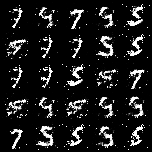

In [18]:
# 이미지 출력
from IPython.display import Image
Image('92000.png')

Q2. 아래사항을 참조하여 로드된 ECG 데이터를 활용하여 이상치 감지 모델을 만든 후 성능 평가를 수행하세요.

[ECG5000 데이터세트]에서 이상을 감지하도록 autoencoder를 훈련합니다. 이 데이터세트에는 각각 140개의 데이터 포인트가 있는 5,000개의 [심전도]가 포함되어 있습니다. 단순화 된 버전의 데이터세트를 사용하고, 각 예제는 `0`(비정상 리듬에 해당) 또는 `1`(정상 리듬에 해당)으로 레이블이 지정됩니다. 

autoencoder를 사용하여 이상을 어떻게 감지하겠습니까? autoencoder는 재구성 오류를 최소화하도록 훈련되었습니다. autoencoder는 정상 리듬으로만 훈련한 다음 이 autoencoder를 사용하여 모든 데이터를 재구성합니다. 여기서 가설은 비정상 리듬의 경우에 재구성 오류가 더 클 것이라는 것입니다. 그런 다음 재구성 오류가 고정 임계값을 초과하는 경우, 리듬을 이상으로 분류합니다.

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# Download the dataset
import pandas as pd
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [20]:
# 데이터셋 분리
labels = raw_data[:, -1]
data = raw_data[:, 0:-1]
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

# 이상치 생성
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

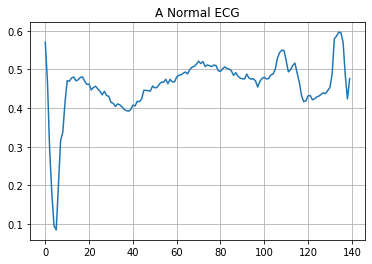

In [21]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

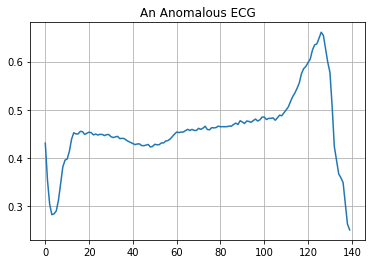

In [22]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [23]:
# 이상치 탐지 클래스
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    # 인코더
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    # 디코더
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [24]:
autoencoder.compile(optimizer='adam', loss='mae')

In [25]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 3s 53ms/step - loss: 0.0578 - val_loss: 0.0532
Epoch 2/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0556 - val_loss: 0.0515
Epoch 3/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0528 - val_loss: 0.0499
Epoch 4/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0493 - val_loss: 0.0486
Epoch 5/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0458 - val_loss: 0.0464
Epoch 6/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0423 - val_loss: 0.0444
Epoch 7/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0393 - val_loss: 0.0432
Epoch 8/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0365 - val_loss: 0.0417
Epoch 9/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0340 - val_loss: 0.0407
Epoch 10/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0320 - val_loss: 0.0398
Epoch 11/20
5/5 [==============

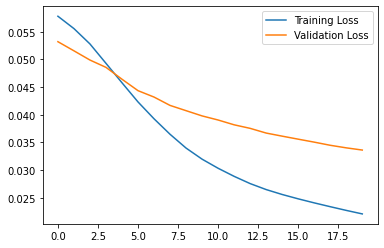

In [26]:
# 성능 평가
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

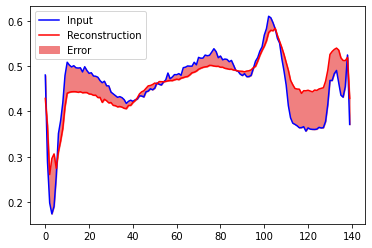

In [27]:
# 정상
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

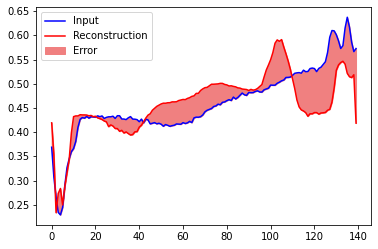

In [28]:
# 이상
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

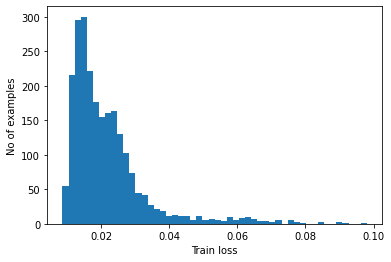

In [29]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Threshold:  0.033389963


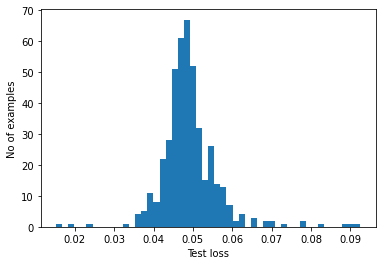

In [30]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [31]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9941176470588236
Recall = 0.9053571428571429


Q3. YOLOv5를 활용하고 포트홀 데이터로 파인튜닝하여 "포트홀 탐지모델"을 개발하고 테스트 데이터 샘플에 대하여 포트홀 탐지가 되는지 확인하세요.

YOLOv5 : https://github.com/ultralytics/yolov5.git<br>
포트홀 데이터 : https://public.roboflow.com/object-detection/pothole

In [32]:
%cd /content
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
from IPython.display import Image, clear_output

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 13599, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 13599 (delta 87), reused 102 (delta 71), pack-reused 13476
Receiving objects: 100% (13599/13599), 12.15 MiB | 30.49 MiB/s, done.
Resolving deltas: 100% (9487/9487), done.
/content/yolov5
     |████████████████████████████████| 596 kB 5.2 MB/s 


In [33]:
%mkdir /content/yolov5/pothole
%cd /content/yolov5/pothole

/content/yolov5/pothole


In [34]:
!curl -L "https://public.roboflow.com/ds/XNDxmWPuXA?key=CDrYCbWVrN" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   1674      0 --:--:-- --:--:-- --:--:--  1674
100 46.0M  100 46.0M    0     0  49.9M      0 --:--:-- --:--:-- --:--:--  173M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/img-105_jpg.rf.3fe9dff3d1631e79ecb480ff403bcb86.jpg  
 extracting: test/images/img-107_jpg.rf.2e40485785f6e5e2efec404301b235c2.jpg  
 extracting: test/images/img-146_jpg.rf.61be25b3053a51f622a244980545df2b.jpg  
 extracting: test/images/img-161_jpg.rf.211541e7178a4a93ec0680f26b905427.jpg  
 extracting: test/images/img-168_jpg.rf.af3590e07b06b43e91fa53990ff94af3.jpg  
 extracting: test/images/img-179_jpg.rf.8632eb0d9b75fefe144829e67b75015a.jpg  
 extracting: test/images/img

In [35]:
from glob import glob 
train_img_list = glob('/content/yolov5/pothole/train/images/*.jpg')
test_img_list = glob('/content/yolov5/pothole/test/images/*.jpg')
valid_img_list = glob('/content/yolov5/pothole/valid/images/*.jpg')

print(len(train_img_list),len(test_img_list),len(valid_img_list))

465 67 133


In [36]:
import yaml
with open('/content/yolov5/pothole/train.txt','w') as f:
  f.write('\n'.join(train_img_list)+'\n')
with open('/content/yolov5/pothole/test.txt','w') as f:
  f.write('\n'.join(test_img_list)+'\n')
with open('/content/yolov5/pothole/valid.txt','w') as f:
  f.write('\n'.join(valid_img_list)+'\n')

In [37]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line,cell):
  with open(line,'w') as f:
    f.write(cell.format(**globals()))

In [38]:
%%writetemplate /content/yolov5/pothole/data.yaml
train: ./pothole/train/images
test: ./pothole/test/images
val: ./pothole/valid/images

nc: 1
names: ['pothole']

In [40]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 1  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [41]:
%%time
%cd /content/yolov5
!python train.py --img 640 --batch 32 --epochs 100 --data ./pothole/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name pothole_results --cache

/content/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=./pothole/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=pothole_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-204-gf43cd53 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, ancho

In [42]:
!python detect.py --weights runs/train/pothole_results/weights/best.pt --img 640 --conf 0.4 --source ./pothole/test/images

detect: weights=['runs/train/pothole_results/weights/best.pt'], source=./pothole/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-204-gf43cd53 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
custom_YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/67 /content/yolov5/pothole/test/images/img-105_jpg.rf.3fe9dff3d1631e79ecb480ff403bcb86.jpg: 640x640 1 pothole, Done. (0.014s)
image 2/67 /content/yolov5/pothole/test/images/img-107_jpg.rf.2e40485785f6e5e2efec404301b235c2.jpg: 640x640 1 pothole, Done. (0.012s)
image 3/67 /content/yolov5/pothole/test/images/img-146_jpg

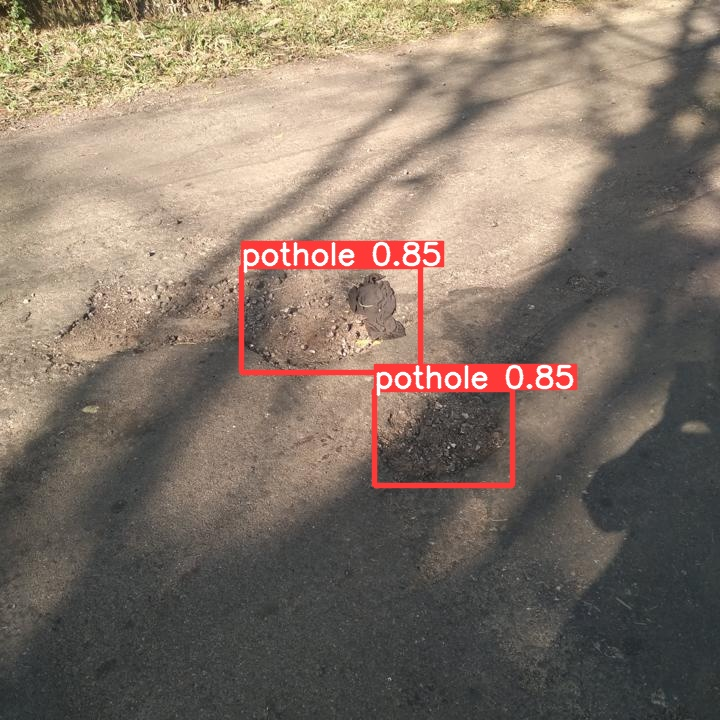

In [47]:
import glob
import random
from IPython.display import Image, display
image_name  = random.choice(glob.glob('/content/yolov5/runs/detect/exp/*.jpg'))
display(Image(filename = image_name))

Q4~5. 주어진 네이버 댓글 데이터 ratings_train.txt, ratings_test.txt 를 활용하여 아래 요구사항에 따라 감성분석 모델 생성 및 평가를 수행하세요.
- pre-trained model로 kobert 사용
- pre-trained model로 bert multilingual 사용

In [48]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 5.2 MB/s 
     |████████████████████████████████| 6.6 MB 41.2 MB/s 
     |████████████████████████████████| 84 kB 2.9 MB/s 


In [49]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 6.8 MB/s 


In [50]:
!pip install sacremoses

     |████████████████████████████████| 880 kB 5.2 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=5457059d8edc242978dc829b64a1e547933dbbeb0ae56d0f5b1cbe9d8c31d6a1
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [51]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import json
from tqdm import tqdm
import os
import re
import sentencepiece as spm

Q4

In [52]:
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 17.55 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [53]:
train = pd.read_table('nsmc/' + 'ratings_train.txt')
test = pd.read_table('nsmc/'+'ratings_test.txt')
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [54]:
# tokenization_kobert.py 업로드
from google.colab import files 
files.upload()

Saving tokenization_kobert.py to tokenization_kobert.py


{'tokenization_kobert.py': b'# coding=utf-8\n# Copyright 2018 Google AI, Google Brain and Carnegie Mellon University Authors and the HuggingFace Inc. team and Jangwon Park\n#\n# Licensed under the Apache License, Version 2.0 (the "License");\n# you may not use this file except in compliance with the License.\n# You may obtain a copy of the License at\n#\n#     http://www.apache.org/licenses/LICENSE-2.0\n#\n# Unless required by applicable law or agreed to in writing, software\n# distributed under the License is distributed on an "AS IS" BASIS,\n# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n# See the License for the specific language governing permissions and\n# limitations under the License.\n""" Tokenization classes for KoBert model."""\n\n\nimport logging\nimport os\nimport unicodedata\nfrom shutil import copyfile\n\nfrom transformers import PreTrainedTokenizer\n\n\nlogger = logging.getLogger(__name__)\n\nVOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3

In [55]:
from tokenization_kobert import KoBertTokenizer
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

https://huggingface.co/monologg/kobert/resolve/main/tokenizer_78b3253a26.model not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpdhdf3uq7


Downloading:   0%|          | 0.00/363k [00:00<?, ?B/s]

storing https://huggingface.co/monologg/kobert/resolve/main/tokenizer_78b3253a26.model in cache at /root/.cache/huggingface/transformers/7e55d7972628e6fc1babc614b5dd8bb43ab4f9d8541adc9fb1851112a7a7c5cc.4d2f4af7c2ca9df5b147978a95d38840e84801a378eee25756b008638e0bdc7f
creating metadata file for /root/.cache/huggingface/transformers/7e55d7972628e6fc1babc614b5dd8bb43ab4f9d8541adc9fb1851112a7a7c5cc.4d2f4af7c2ca9df5b147978a95d38840e84801a378eee25756b008638e0bdc7f
https://huggingface.co/monologg/kobert/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp2he4wtmk


Downloading:   0%|          | 0.00/76.0k [00:00<?, ?B/s]

storing https://huggingface.co/monologg/kobert/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/efee434f5f4c5c89b5a7d8d5f30bbb0496f1540349fcfa21729cec5b96cfd2d1.719459e20bc981bc2093e859b02c3a3e51bab724d6b58927b23b512a3981229f
creating metadata file for /root/.cache/huggingface/transformers/efee434f5f4c5c89b5a7d8d5f30bbb0496f1540349fcfa21729cec5b96cfd2d1.719459e20bc981bc2093e859b02c3a3e51bab724d6b58927b23b512a3981229f
https://huggingface.co/monologg/kobert/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmply5b82u6


Downloading:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

storing https://huggingface.co/monologg/kobert/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/d1c07e179f5e00959a3c8e4a150eaa4907dfe26544e4a71f2b0163982a476523.767d1b760a83978bae6c324157fad57ee513af333a7cea6986e852579f6f0dd1
creating metadata file for /root/.cache/huggingface/transformers/d1c07e179f5e00959a3c8e4a150eaa4907dfe26544e4a71f2b0163982a476523.767d1b760a83978bae6c324157fad57ee513af333a7cea6986e852579f6f0dd1
loading file https://huggingface.co/monologg/kobert/resolve/main/tokenizer_78b3253a26.model from cache at /root/.cache/huggingface/transformers/7e55d7972628e6fc1babc614b5dd8bb43ab4f9d8541adc9fb1851112a7a7c5cc.4d2f4af7c2ca9df5b147978a95d38840e84801a378eee25756b008638e0bdc7f
loading file https://huggingface.co/monologg/kobert/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/efee434f5f4c5c89b5a7d8d5f30bbb0496f1540349fcfa21729cec5b96cfd2d1.719459e20bc981bc2093e859b02c3a3e51bab724d6b58927b23b512a3981229f
loading file

Downloading:   0%|          | 0.00/426 [00:00<?, ?B/s]

storing https://huggingface.co/monologg/kobert/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/31dc8da633439f22ed80bede01f337996bc709eb8429f86f2b24e2103558b039.89a06cdfd16840fd89cc5c2493ef63cd0b6068e85f70ac988a3673e2722cab2e
creating metadata file for /root/.cache/huggingface/transformers/31dc8da633439f22ed80bede01f337996bc709eb8429f86f2b24e2103558b039.89a06cdfd16840fd89cc5c2493ef63cd0b6068e85f70ac988a3673e2722cab2e
loading configuration file https://huggingface.co/monologg/kobert/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/31dc8da633439f22ed80bede01f337996bc709eb8429f86f2b24e2103558b039.89a06cdfd16840fd89cc5c2493ef63cd0b6068e85f70ac988a3673e2722cab2e
Model config BertConfig {
  "_name_or_path": "monologg/kobert",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,


In [56]:
def convert_data(data_df):
  global tokenizer
  SEQ_LEN = 64

  tokens, masks, segments, targets = [],[],[],[]

  for i in tqdm(range(len(data_df))):
    token = tokenizer.encode(data_df[DATA_COLUMN][i], truncation=True, padding='max_length',max_length=SEQ_LEN)
    num_zeros = token.count(0)
    mask = [1] * (SEQ_LEN-num_zeros) + [0] * num_zeros
    segment = [0] * SEQ_LEN

    tokens.append(token)
    masks.append(mask)
    segments.append(segment)

    targets.append(data_df[LABEL_COLUMN][i])

  tokens = np.array(tokens)
  masks = np.array(masks)
  segments = np.array(segments)
  targets = np.array(targets)

  return [tokens, masks, segments], targets

In [57]:
def load_data(pandas_dataframe):
  data_df = pandas_dataframe
  data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
  data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
  data_x,data_y = convert_data(data_df)
  return data_x, data_y

SEQ_LEN = 64
BATCH_SIZE = 32
DATA_COLUMN = 'document'
LABEL_COLUMN = 'label'

train_x, train_y = load_data(train)

100%|██████████| 150000/150000 [00:44<00:00, 3374.05it/s]


In [58]:
test_x, test_y = load_data(test)

100%|██████████| 50000/50000 [00:14<00:00, 3386.25it/s]


In [59]:
model = TFBertModel.from_pretrained('monologg/kobert', from_pt=True)
token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')

bert_output = model([token_inputs, mask_inputs, segment_inputs])

loading configuration file https://huggingface.co/monologg/kobert/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/31dc8da633439f22ed80bede01f337996bc709eb8429f86f2b24e2103558b039.89a06cdfd16840fd89cc5c2493ef63cd0b6068e85f70ac988a3673e2722cab2e
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 8002
}

https://huggingface.co/monologg/kobert/resolve/main/pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/

Downloading:   0%|          | 0.00/352M [00:00<?, ?B/s]

storing https://huggingface.co/monologg/kobert/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/9525d6f96682baa1f21538ea58d36263fe16a46345dd9637e3e28a4df2f9380f.ebe6e13ff204bebbffd4764cda3d5a97dc690a9c4110bde6d909ddc3ed5c4585
creating metadata file for /root/.cache/huggingface/transformers/9525d6f96682baa1f21538ea58d36263fe16a46345dd9637e3e28a4df2f9380f.ebe6e13ff204bebbffd4764cda3d5a97dc690a9c4110bde6d909ddc3ed5c4585
loading weights file https://huggingface.co/monologg/kobert/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9525d6f96682baa1f21538ea58d36263fe16a46345dd9637e3e28a4df2f9380f.ebe6e13ff204bebbffd4764cda3d5a97dc690a9c4110bde6d909ddc3ed5c4585
Loading PyTorch weights from /root/.cache/huggingface/transformers/9525d6f96682baa1f21538ea58d36263fe16a46345dd9637e3e28a4df2f9380f.ebe6e13ff204bebbffd4764cda3d5a97dc690a9c4110bde6d909ddc3ed5c4585
PyTorch checkpoint contains 92,186,880 parameters
Loaded 92,186,880 parameter

In [60]:
bert_output = bert_output[1]
bert_output.shape

TensorShape([None, 768])

In [61]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 4.9 MB/s 


In [62]:
import tensorflow_addons as tfa
opt = tfa.optimizers.RectifiedAdam(lr=5.0e-5, total_steps=2344*2,warmup_proportion=0.1, min_lr=1e-5,epsilon=1e-08, clipnorm=1.0)

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/optimizers/rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [63]:
sentiment_drop = tf.keras.layers.Dropout(0.5)(bert_output)
sentiment_first = tf.keras.layers.Dense(1,activation='sigmoid',kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(sentiment_drop)
sentiment_model = tf.keras.Model([token_inputs,mask_inputs,segment_inputs],sentiment_first)
sentiment_model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [64]:
sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 64)]         0           []                               
                                                                                                  
 input_segment (InputLayer)     [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  92186880    ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_masks[0][0]',        

In [65]:
sentiment_model.fit(train_x,train_y,epochs=2,shuffle=True,batch_size=64,validation_data=(test_x,test_y))

Epoch 1/2
2344/2344 [==============================] - 1359s 560ms/step - loss: 0.3731 - accuracy: 0.8209 - val_loss: 0.2771 - val_accuracy: 0.8813
Epoch 2/2
2344/2344 [==============================] - 1305s 557ms/step - loss: 0.2365 - accuracy: 0.9041 - val_loss: 0.2689 - val_accuracy: 0.8958


In [66]:
sentiment_model.evaluate(test_x,test_y)

1563/1563 [==============================] - 159s 101ms/step - loss: 0.2689 - accuracy: 0.8958


[0.2688513994216919, 0.8957800269126892]

Q5

In [67]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

In [68]:
train = pd.read_csv("nsmc/ratings_train.txt", sep='\t')
test = pd.read_csv("nsmc/ratings_test.txt", sep='\t')

print(train.shape)
print(test.shape)

(150000, 3)
(50000, 3)


In [69]:
sentences = train['document']
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP]',
 '[CLS] 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나 [SEP]',
 '[CLS] 너무재밓었다그래서보는것을추천한다 [SEP]',
 '[CLS] 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정 [SEP]',
 '[CLS] 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다 [SEP]',
 '[CLS] 막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움. [SEP]',
 '[CLS] 원작의 긴장감을 제대로 살려내지못했다. [SEP]',
 '[CLS] 별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네 [SEP]',
 '[CLS] 액션이 없는데도 재미 있는 몇안되는 영화 [SEP]',
 '[CLS] 왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나? [SEP]']

In [70]:
labels = train['label'].values
labels

array([0, 1, 0, ..., 0, 1, 0])

In [71]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

https://huggingface.co/bert-base-multilingual-cased/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpu8sqsof8


Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-multilingual-cased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/eff018e45de5364a8368df1f2df3461d506e2a111e9dd50af1fae061cd460ead.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
creating metadata file for /root/.cache/huggingface/transformers/eff018e45de5364a8368df1f2df3461d506e2a111e9dd50af1fae061cd460ead.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
https://huggingface.co/bert-base-multilingual-cased/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpjaynsj9k


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-multilingual-cased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/f55e7a2ad4f8d0fff2733b3f79777e1e99247f2e4583703e92ce74453af8c235.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
creating metadata file for /root/.cache/huggingface/transformers/f55e7a2ad4f8d0fff2733b3f79777e1e99247f2e4583703e92ce74453af8c235.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/eff018e45de5364a8368df1f2df3461d506e2a111e9dd50af1fae061cd460ead.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://hug

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-multilingual-cased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c
creating metadata file for /root/.cache/huggingface/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c
loading configuration file https://huggingface.co/bert-base-multilingual-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidde

[CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP]
['[CLS]', '아', '더', '##빙', '.', '.', '진', '##짜', '짜', '##증', '##나', '##네', '##요', '목', '##소', '##리', '[SEP]']


In [72]:
MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([   101,   9519,   9074, 119005,    119,    119,   9708, 119235,
         9715, 119230,  16439,  77884,  48549,   9284,  22333,  12692,
          102,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [73]:
attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [74]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=2018, 
                                                                                    test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=2018, 
                                                       test_size=0.1)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)				

print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

tensor([   101,   9711,  11489,   9364,  41850,   9004,  32537,   9491,  35506,
         17360,  48549,    119,    119,   9477,  26444,  12692,   9665,  21789,
         11287,   9708, 119235,   9659,  22458, 119136,  12965,  48549,    119,
           119,   9532,  22879,   9685,  16985,  14523,  48549,    119,    119,
          9596, 118728,    119,    119,   9178, 106065, 118916,    119,    119,
          8903,  11664,  11513,   9960,  14423,  25503, 118671,  48549,    119,
           119,  21890,   9546,  37819,  22879,   9356,  14867,   9715, 119230,
        118716,  48345,    119,   9663,  23321,  10954,   9638,  35506, 106320,
         10739,  20173,   9359,  19105,  11102,  42428,  17196,  48549,    119,
           119,    100,    117,   9947,  12945,   9532,  25503,   8932,  14423,
         35506, 119050,  11903,  14867,  10003,  14863,  33188,  48345,    119,
           102,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [75]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [76]:
sentences = test['document']
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 굳 ㅋ [SEP]',
 '[CLS] GDNTOPCLASSINTHECLUB [SEP]',
 '[CLS] 뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아 [SEP]',
 '[CLS] 지루하지는 않은데 완전 막장임... 돈주고 보기에는.... [SEP]',
 '[CLS] 3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠?? [SEP]',
 '[CLS] 음악이 주가 된, 최고의 음악영화 [SEP]',
 '[CLS] 진정한 쓰레기 [SEP]',
 '[CLS] 마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다 [SEP]',
 '[CLS] 갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한cg남무 아 그립다 동사서독같은 영화가 이건 3류아류작이다 [SEP]',
 '[CLS] 이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네.. [SEP]']

In [77]:
labels = test['label'].values
labels

array([1, 0, 0, ..., 0, 0, 0])

In [78]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/eff018e45de5364a8368df1f2df3461d506e2a111e9dd50af1fae061cd460ead.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/f55e7a2ad4f8d0fff2733b3f79777e1e99247f2e4583703e92ce74453af8c235.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
loading configuration file https://huggingface.co/bert-base-multilingual-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515

[CLS] 굳 ㅋ [SEP]
['[CLS]', '굳', '[UNK]', '[SEP]']


In [84]:
MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([ 101, 8911,  100,  102,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [85]:
attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [86]:
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

print(test_inputs[0])
print(test_labels[0])
print(test_masks[0])

tensor([ 101, 8911,  100,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
tensor(1)
tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [87]:
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [88]:
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [89]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [90]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

loading configuration file https://huggingface.co/bert-base-multilingual-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-multilingual-cased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/0a3fd51713dcbb4def175c7f85bddc995d5976ce1dde327f99104e4d33069f17.aa7be4c79d76f4066d9b354496ea477c9ee39c5d889156dd1efb680643c2b052
creating metadata file for /root/.cache/huggingface/transformers/0a3fd51713dcbb4def175c7f85bddc995d5976ce1dde327f99104e4d33069f17.aa7be4c79d76f4066d9b354496ea477c9ee39c5d889156dd1efb680643c2b052
loading weights file https://huggingface.co/bert-base-multilingual-cased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/0a3fd51713dcbb4def175c7f85bddc995d5976ce1dde327f99104e4d33069f17.aa7be4c79d76f4066d9b354496ea477c9ee39c5d889156dd1efb680643c2b052
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [91]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8 
                )

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [92]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [93]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [94]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.zero_grad()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0


    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
           
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        model.zero_grad()

    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():    
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch   500  of  4,219.    Elapsed: 0:03:13.
  Batch 1,000  of  4,219.    Elapsed: 0:06:26.
  Batch 1,500  of  4,219.    Elapsed: 0:09:39.
  Batch 2,000  of  4,219.    Elapsed: 0:12:52.
  Batch 2,500  of  4,219.    Elapsed: 0:16:05.
  Batch 3,000  of  4,219.    Elapsed: 0:19:18.
  Batch 3,500  of  4,219.    Elapsed: 0:22:31.
  Batch 4,000  of  4,219.    Elapsed: 0:25:44.

  Average training loss: 0.38
  Training epcoh took: 0:27:09

Running Validation...
  Accuracy: 0.85
  Validation took: 0:00:54

======== Epoch 2 / 4 ========
Training...
  Batch   500  of  4,219.    Elapsed: 0:03:13.
  Batch 1,000  of  4,219.    Elapsed: 0:06:26.
  Batch 1,500  of  4,219.    Elapsed: 0:09:39.
  Batch 2,000  of  4,219.    Elapsed: 0:12:53.
  Batch 2,500  of  4,219.    Elapsed: 0:16:06.
  Batch 3,000  of  4,219.    Elapsed: 0:19:18.
  Batch 3,500  of  4,219.    Elapsed: 0:22:31.
  Batch 4,000  of  4,219.    Elapsed: 0:25:44.

  Average training loss: 0.28
  

In [95]:
t0 = time.time()

model.eval()

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

for step, batch in enumerate(test_dataloader):
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():     

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    

    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

  Batch   100  of  1,563.    Elapsed: 0:00:12.
  Batch   200  of  1,563.    Elapsed: 0:00:23.
  Batch   300  of  1,563.    Elapsed: 0:00:35.
  Batch   400  of  1,563.    Elapsed: 0:00:46.
  Batch   500  of  1,563.    Elapsed: 0:00:58.
  Batch   600  of  1,563.    Elapsed: 0:01:09.
  Batch   700  of  1,563.    Elapsed: 0:01:21.
  Batch   800  of  1,563.    Elapsed: 0:01:33.
  Batch   900  of  1,563.    Elapsed: 0:01:44.
  Batch 1,000  of  1,563.    Elapsed: 0:01:56.
  Batch 1,100  of  1,563.    Elapsed: 0:02:07.
  Batch 1,200  of  1,563.    Elapsed: 0:02:19.
  Batch 1,300  of  1,563.    Elapsed: 0:02:31.
  Batch 1,400  of  1,563.    Elapsed: 0:02:42.
  Batch 1,500  of  1,563.    Elapsed: 0:02:54.

Accuracy: 0.87
Test took: 0:03:01
